In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
def list_experiments(variableName="cVeg"):
    exps = set()
    for filename in os.listdir():
        if filename.startswith(variableName):
            #print(filename)
            exps.add(filename.split("_")[2])
    return exps


def load(variableName="cVeg", experiment="CanESM5"):
    experimentfiles = []
    for filename in os.listdir():
        if filename.startswith(variableName) and filename.split("_")[2].lower() == experiment.lower():
            experimentfiles.append(filename)
    
    experimentfiles.sort()
    nplist = []
    
    for filename in experimentfiles:
        arr = xr.open_dataset(filename)[variableName].to_numpy()
        nplist.append(arr)

    final = np.concatenate(nplist)    
    return final    

In [4]:
start_x = 12*(0) # 1850
end_x = 12*(25) # 1875
start_y = 12*(75) # 1925
end_y = 12*(100) # 1950

def avg20(ds):
    return np.mean(ds, axis=0) # axis of mean = time

In [5]:
from sklearn.linear_model import LinearRegression

In [79]:
def plot_and_test(input, output, mask,color=None,ax=plt):
    output = output[mask].flatten()
    input = input[mask].flatten()
    
    ax.scatter(input, output, alpha=0.2, color=color)

def fit_and_test(inputs, output, mask, test_inputs, test_output, title=""):
    modelshape = inputs[0].shape

    # Setup plots
    fig, axs = plt.subplots(3 + len(inputs), 2, figsize=(12, 12 + 4 * len(inputs)))
    fig.suptitle(title)
    output[~mask] = np.nan
    test_output[~mask] = np.nan
    axs[0][0].imshow(output[::-1], vmin=0, vmax=16)
    pcm0 = axs[0][1].imshow(test_output[::-1], vmin=0, vmax=16)
    fig.colorbar(pcm0, ax=axs[0][1])

    axs[0][0].set_ylabel("CMIP")
    axs[1][0].set_ylabel("Predicted")
    axs[2][0].set_ylabel("Residuals")

    axs[0][0].set_title("Historical")
    axs[0][1].set_title("Future")
    
    labels = ["Temp." , "Precip.", "VPD"]
    for i in range(len(inputs)):
        axs[3+i][0].scatter(inputs[i][mask], output[mask], alpha=0.3)
        axs[3+i][1].scatter(test_inputs[i][mask], test_output[mask], alpha=0.3)
        axs[3+i][0].set_ylabel(labels[i] + " vs cVeg")

    # Prepare and mask inputs/outputs for linreg
    for i in range(len(inputs)):
        inputs[i] = inputs[i][mask].flatten()
        test_inputs[i] = test_inputs[i][mask].flatten()
    inputs = np.array(inputs).transpose()
    test_inputs = np.array(test_inputs).transpose()
    
    output = output[mask].flatten()
    test_output = test_output[mask].flatten()

    # Fit and score model
    model = LinearRegression()
    model.fit(inputs, output)

    R2_present = model.score(inputs, output)
    R2_future = model.score(test_inputs, test_output)

    predicted_present = np.full(modelshape, np.nan)
    predicted_future = np.full(modelshape, np.nan)
    predicted_present[mask] = model.predict(inputs) 
    predicted_future[mask] = model.predict(test_inputs)

    cmip_present = np.full(modelshape, np.nan)
    cmip_future = np.full(modelshape, np.nan)
    cmip_present[mask] = output  
    cmip_future[mask] = test_output

    axs[1][0].imshow(predicted_present[::-1], vmin=0, vmax=16)
    pcm1 = axs[1][1].imshow(predicted_future[::-1], vmin=0, vmax=16)
    fig.colorbar(pcm1, ax=axs[1][1])

    axs[2][0].imshow(predicted_present[::-1] - cmip_present[::-1], vmin=-5, vmax=5, cmap="coolwarm")
    pcm2 = axs[2][1].imshow(predicted_future[::-1] - cmip_future[::-1], vmin=-5, vmax=5, cmap="coolwarm")
    fig.colorbar(pcm2, ax=axs[2][1])
    
    plt.savefig(title+'.png')
    
    print(title, "*", model.coef_, "+", model.intercept_)
    print(title, "R^2 Present", R2_present)
    print(title, "R^2 Future", R2_future) 
    
    return model

In [7]:
# Choose r to make sphere surface area 1 for easy multiplication later
# r = sqrt(1/4pi)
r = np.sqrt(1/(4*np.pi))

# Gets height of section of sphere given two angles
def getH(angles):
    angle_min = np.min(angles)
    angle_max = np.max(angles)
    
    # Hypotenuse = r
    # Hypotenuse * sin(Theta) = Opposite
    h_min = r * np.sin(angle_min)
    h_max = r * np.sin(angle_max)
    return h_max - h_min

# https://en.wikipedia.org/wiki/Spherical_segment
def getArea(horizontal_angles,vertical_angles,in_degrees=True):
    if in_degrees: # We need radians
        horizontal_angles *= (np.pi / 180)
        vertical_angles *= (np.pi / 180)

    left_bound = np.min(horizontal_angles)
    right_bound = np.max(horizontal_angles)
    arc_horz = right_bound - left_bound

    # 2 * pi * r * h * arc2
    return 2 * np.pi * r * getH(vertical_angles) * (arc_horz/(2*np.pi))

# should theoretically equal 1
print(getArea(np.array([-180,180], dtype=np.float64),np.array([90,-90], dtype=np.float64)))

def cuts(amount_vertical,amount_horizontal,vstart=90):
    space = np.linspace(-vstart,vstart,amount_vertical+1)
    width = 360/amount_horizontal
    y = []
    # We only care about vertical dimension
    for i in range(amount_vertical):
        y.append(getArea(np.array([0,width], dtype=np.float64), np.array([space[i],space[i+1]], dtype=np.float64)))
    x = np.array([y] * amount_horizontal)
    return x.transpose()

#cuts(10,5) # This may be in the wrong orientation but we can always transpose    

0.9999999999999999


/usr/lib/python3.12/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/usr/lib/python3.12/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/lib/python3.12/site-packages/xarray/core/indexing.py:529: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/u

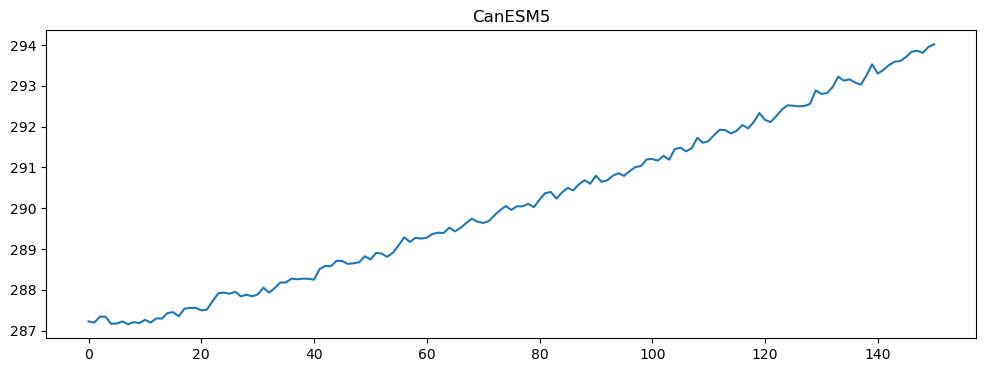

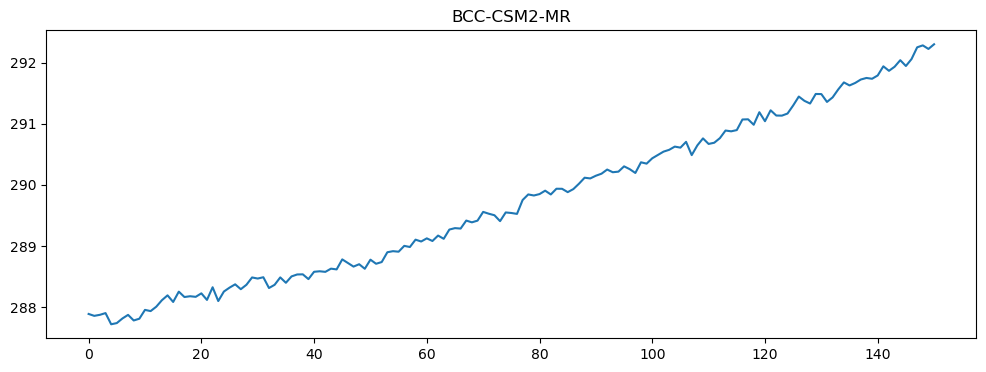

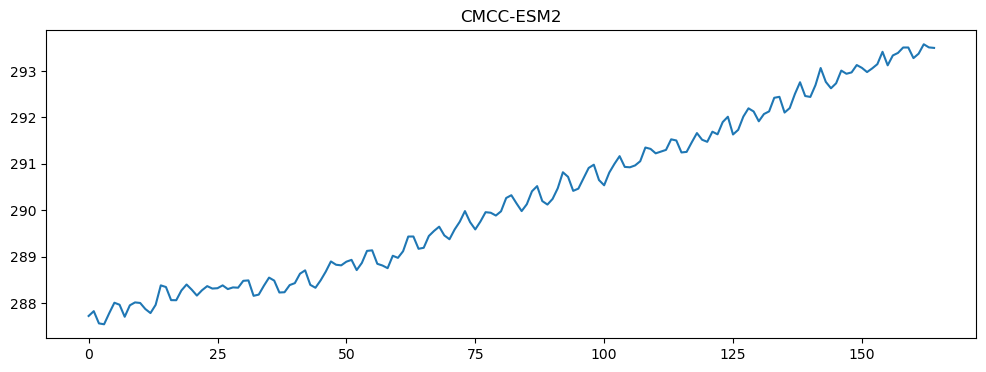

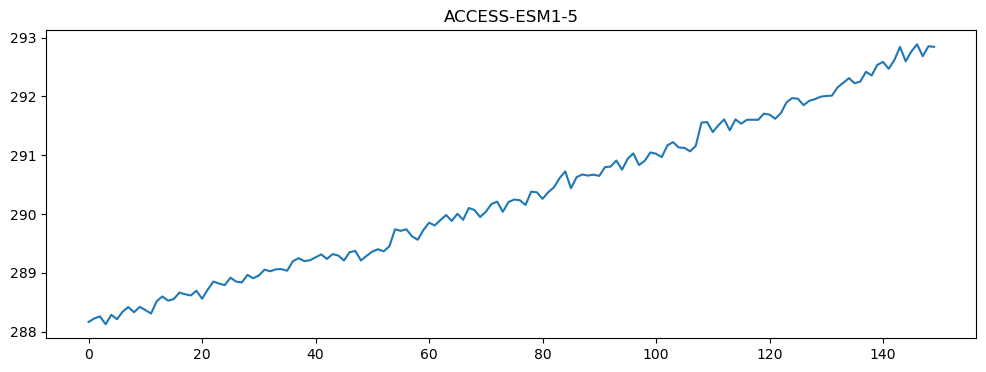

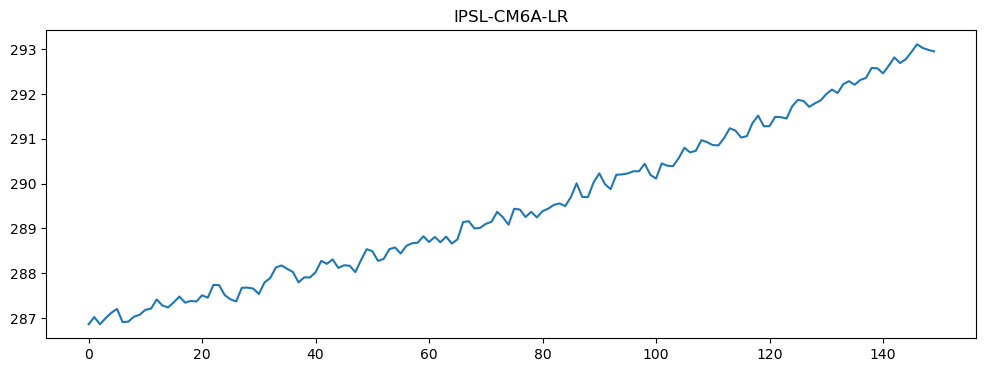

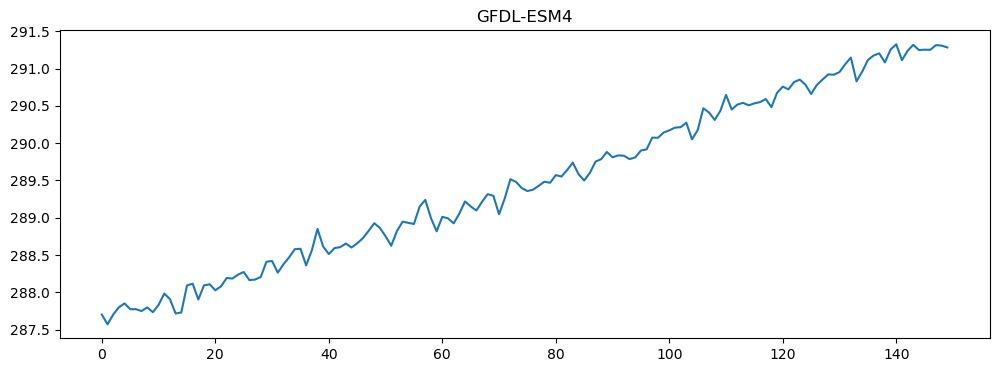

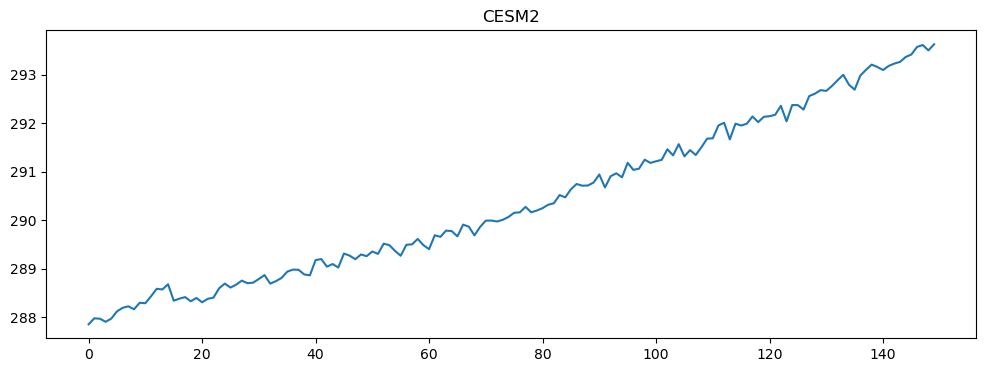

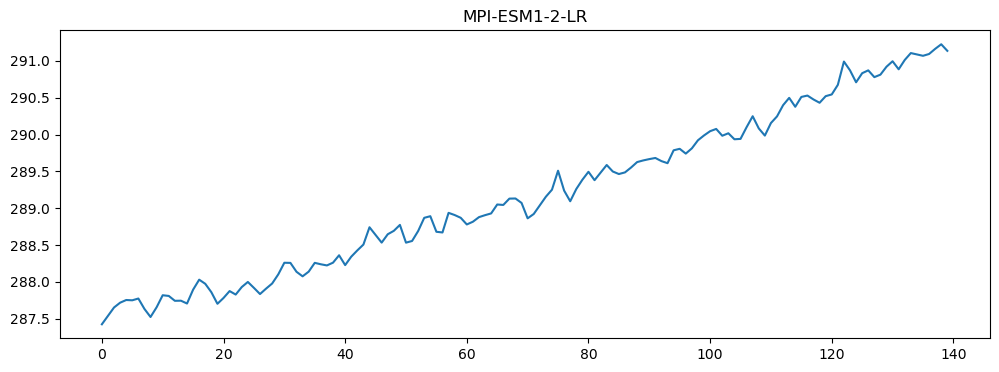

In [8]:
def timeseries(values, name=""):
    i = 0
    weights = cuts(values.shape[1],values.shape[2])

    plt.figure(figsize=(12,4))
    
    values = np.nan_to_num(values)
    monthly = np.sum(values * weights, axis=(1,2))
    yearly = np.mean(monthly.reshape(-1, 12), axis=1)
    
    plt.plot(yearly)
    plt.title(name)

for expname in list_experiments("ts"):
    timeseries(load("ts", expname), expname)

In [9]:
def vpd(ts, hurs):
    ts_c = ts - 273.15
    vpsat = 6.1094 * np.exp(17.625 * ts_c / (ts_c + 243.04)) # in hPa, from claus-clap wikipedia page
    #plt.imshow(vpsat)
    #plt.colorbar()

    vpd = (vpsat/10) * ((100-hurs)/100) # from vpd wikipedia page, unit shouldnt matter because scaler * percent?
    return vpd

In [ ]:
for expname in list_experiments("hurs"):
    cveg_data = load("cVeg", expname)
    pr_data = load("pr", expname)
    ts_data = load("ts", expname)
    hurs_data = load("hurs", expname)
    
    x_cveg = avg20(cveg_data[start_x:end_x,:,:])
    x_ts = avg20(ts_data[start_x:end_x,:,:])
    x_pr = avg20(pr_data[start_x:end_x,:,:])
    x_hurs = avg20(hurs_data[start_x:end_x,:,:])
    #x_gpp = avg20(gpp_data[start_x:end_x,:,:])
    y_ts = avg20(ts_data[start_y:end_y,:,:])
    y_pr = avg20(pr_data[start_y:end_y,:,:])
    y_hurs = avg20(hurs_data[start_y:end_y,:,:])
    #y_gpp = avg20(gpp_data[start_y:end_y,:,:])
    y_cveg = avg20(cveg_data[start_y:end_y,:,:])

    x_vpd = vpd(x_ts, x_hurs)
    y_vpd = vpd(y_ts, y_hurs)
    
    #plt.imshow(x_vpd[::-1], vmin=0, vmax=2.5)
    #plt.colorbar()
    #break

    tropics = np.full([x_cveg.shape[0],x_cveg.shape[1]], False)
    tropics[x_cveg.shape[0]//3:2*x_cveg.shape[0]//3,:] = True

    mask1 = (x_cveg > 0) & tropics
    mask2 = (x_cveg > 0) & ~tropics
    
    fit_and_test([np.copy(x_ts), np.copy(x_pr), np.copy(x_vpd)], np.copy(x_cveg), mask1, [np.copy(y_ts), np.copy(y_pr), np.copy(y_vpd)], np.copy(y_cveg), expname + " Tropical")
    fit_and_test([np.copy(x_ts), np.copy(x_pr), np.copy(x_vpd)], np.copy(x_cveg), mask2, [np.copy(y_ts), np.copy(y_pr), np.copy(y_vpd)], np.copy(y_cveg), expname + " ExtraTropical")

CanESM5 Tropical * [ 6.9006279e-02  8.1873062e+04 -2.3046875e+00] + -16.393684
CanESM5 Tropical R^2 Present 0.6944609612417202
CanESM5 Tropical R^2 Future 0.6074932660227204
CanESM5 ExtraTropical * [ 1.4163451e-01  1.1920527e+05 -2.7265625e+00] + -37.546238
CanESM5 ExtraTropical R^2 Present 0.4494738545548488
CanESM5 ExtraTropical R^2 Future 0.4166462039790555
CMCC-ESM2 Tropical * [ 3.2661805e-01  7.4117469e+04 -5.5937500e+00] + -89.198044
CMCC-ESM2 Tropical R^2 Present 0.4709342176069623
CMCC-ESM2 Tropical R^2 Future 0.45510384374717106
CMCC-ESM2 ExtraTropical * [ 8.4596574e-02  8.5344906e+04 -2.8359375e+00] + -22.098192
CMCC-ESM2 ExtraTropical R^2 Present 0.30233877913383567
CMCC-ESM2 ExtraTropical R^2 Future 0.2800126066861932


/usr/lib/python3.12/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/usr/lib/python3.12/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/lib/python3.12/site-packages/xarray/core/indexing.py:529: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/u

ACCESS-ESM1-5 Tropical * [-2.2327892e-01  9.4513805e+04 -1.8828125e+00] + 70.24526
ACCESS-ESM1-5 Tropical R^2 Present 0.5266850923460253
ACCESS-ESM1-5 Tropical R^2 Future 0.47797963607877947
ACCESS-ESM1-5 ExtraTropical * [ 3.1593055e-01  4.1347859e+04 -1.0515625e+01] + -82.13944
ACCESS-ESM1-5 ExtraTropical R^2 Present 0.34983219594342885
ACCESS-ESM1-5 ExtraTropical R^2 Future 0.2312746412243032
IPSL-CM6A-LR Tropical * [ 3.3533406e-01  2.7709189e+04 -4.8808594e+00] + -90.95649
IPSL-CM6A-LR Tropical R^2 Present 0.5746687906677714
IPSL-CM6A-LR Tropical R^2 Future 0.4701746587489315
IPSL-CM6A-LR ExtraTropical * [ 6.9379300e-02  3.9532164e+04 -1.3984375e+00] + -18.507328
IPSL-CM6A-LR ExtraTropical R^2 Present 0.3143533607530673
IPSL-CM6A-LR ExtraTropical R^2 Future 0.2813759482557222


/usr/lib/python3.12/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'cVeg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.12/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'cVeg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.12/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'cVeg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.12/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.12/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = deco

CESM2 Tropical * [ 2.7903524e-01  1.2028394e+05 -3.9218750e+00] + -77.05632
CESM2 Tropical R^2 Present 0.685710625063104
CESM2 Tropical R^2 Future 0.6258936322597162
CESM2 ExtraTropical * [ 1.5914308e-01  7.5309031e+04 -6.0390625e+00] + -40.27577
CESM2 ExtraTropical R^2 Present 0.2700139945668396
CESM2 ExtraTropical R^2 Future 0.278127802367482
GFDL-ESM4 Tropical * [-6.32382929e-02  1.15261914e+05 -3.90625000e-01] + 18.081848
GFDL-ESM4 Tropical R^2 Present 0.37900807564425865
GFDL-ESM4 Tropical R^2 Future 0.35245539141581383
GFDL-ESM4 ExtraTropical * [ 2.5422307e-02  1.0371400e+05 -3.4921875e+00] + -5.086979
GFDL-ESM4 ExtraTropical R^2 Present 0.42524014895202034
GFDL-ESM4 ExtraTropical R^2 Future 0.4055347478333169
